In [5]:
import os

# Change to the parent directory
os.chdir('../..')

# Verify the path using getcwd()
cwd = os.getcwd()
print("Current working directory:", cwd)

Current working directory: c:\Users\onyer\OneDrive\Desktop\Research work


In [6]:
import pandas as pd
import math
import numpy as np
import control as ct
import matplotlib.pyplot as plt
import scipy as sp
import src.file_loader as fl
import src.sysid_util as sid
import src.data_processing as dp
import src.plotting as plot
import scipy.signal as signal
from scipy.signal import TransferFunction

In [ ]:
charging_cycles = dp.find_charging_cycles(df4)

Transfer function of data generating system:
<TransferFunction>: sys[4]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


3e+04 s^2 + 1348 s + 1.9
------------------------
 3e+04 s^2 + 1030 s + 1

Normalized Transfer Function:
<TransferFunction>: sys[5]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


s^2 + 0.04493 s + 6.333e-05
---------------------------
s^2 + 0.03433 s + 3.333e-05

Discrete-Time Transfer Function H(z):


TransferFunction(array([ 1.00005299, -1.99965672,  0.99960374]), array([ 1.        , -1.99965672,  0.99965673]), 0.01)

   Time (s)  Input (u)  Output (y)
0      0.00        0.0         0.0
1      0.01        0.0         0.0
2      0.02        0.0         0.0
3      0.03        0.0         0.0
4      0.04        0.0         0.0


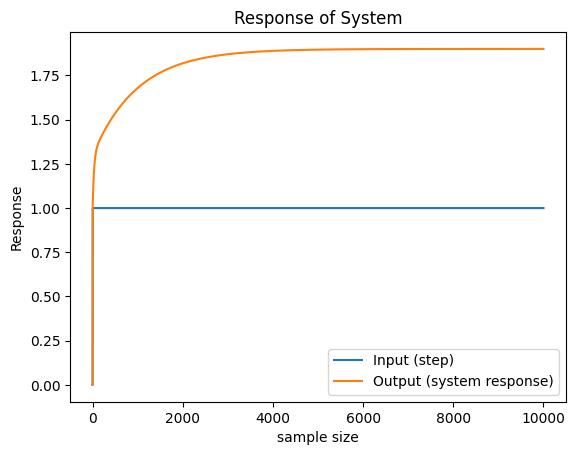

In [7]:
# The transfer function is
'''Y(s) = H(s)U(s)
    where H(s) = (R1/R1C1s+1) + (R2/R2C2s+1) + (Rn/RnCns+1) + R0
    Y(s) = (R1/R1C1s+1)U(s) + (R2/R2C2s+1)U(s) + R0U(s) for second order system as n = 2
'''

# System Parameters
R0 = 1  # 1 mΩ
R1 = 0.3  # 0.3 mΩ
R2 = 0.6  # 0.6 mΩ
tau1 = 30  # 30s
tau2 = 1000  # 1000s
C1 = tau1 / R1  # Derived from τ = RC #100
C2 = tau2 / R2 # 1666.67


# Continuous-Time Transfer Function H(s)
num1, den1 = [R1], [R1 * C1, 1]
num2, den2 = [R2], [R2 * C2, 1]
num3, den3 = [R0], [1]  # Static gain

H1 = ct.TransferFunction(num1, den1)
H2 = ct.TransferFunction(num2, den2)
H3 = ct.TransferFunction(num3, den3)
H = H1 + H2 + H3  # Total system transfer function

print('Transfer function of data generating system:')
print(H)

# Normalize denominator
num, den = H.num[0][0], H.den[0][0]  # Extract coefficients
den_leading_coeff = den[0]  # Leading coefficient of denominator
num_normalized = [n / den_leading_coeff for n in num]
den_normalized = [d / den_leading_coeff for d in den]

H_normalized = ct.TransferFunction(num_normalized, den_normalized)
print("Normalized Transfer Function:")
print(H_normalized)

# Discretization
dt = 1/100  # Sampling period
H_discrete = ct.c2d(H_normalized, dt, method='tustin')

print("Discrete-Time Transfer Function H(z):")
display(H_discrete)

N = 1000000
t = np.linspace(0,dt*N,N)

u_step = np.ones(N)
u_step[0:100] = np.zeros(100)


# Simulate system response
tout, yout= ct.forced_response(H, T=t, U=u_step)

# Store response in DataFrame
system_df = pd.DataFrame({
    "Time (s)": tout,
    "Input (u)": u_step,
    "Output (y)": yout
})

# Display the first few rows
print(system_df.head())

# Plot response
fig, ax = plt.subplots()
ax.plot(t, u_step, label="Input (step)")
ax.plot(tout, yout, label="Output (system response)")
ax.set_title("Response of System")
ax.set_xlabel("sample size")
ax.set_ylabel("Response")
ax.legend()
plt.show()

In [8]:
num_est,den_est = H_discrete.num, H_discrete.den
num_est = num_est[0][0]
den_est = den_est[0][0]

print(H_discrete)
print(den_est)

<TransferFunction>: sys[5]$sampled
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


z^2 - 2 z + 0.9996
------------------
z^2 - 2 z + 0.9997

dt = 0.01

[ 1.         -1.99965672  0.99965673]


In [9]:
def eval_poly(coeffs, x):
    """Evaluate polynomial at a specific point."""
    return np.polyval(coeffs, x)

def partial_fraction_expansion(num, den):
    """Performs partial fraction expansion."""
    
    # Convert to numpy arrays
    num = np.array(num)
    den = np.array(den)

    # Normalize the denominator
    a0 = float(den[0])
    den_normalized = den / a0
    
    # Find the poles
    poles = np.roots(den_normalized)
    num_poles = poles.shape[0]
    
    # Initialize coefficients
    coeff = np.zeros(num_poles, dtype=np.complex128) 
    
    # Compute the residues
    for i in range(num_poles):
        numerator_at_pole = eval_poly(num, poles[i])
        denominator_product = np.prod([(poles[i] - poles[j]) for j in range(num_poles) if i != j])
        coeff[i] = numerator_at_pole / (denominator_product * a0)
    
    return poles, coeff

# Extract the array from the list
# num_est = num_est[0]

# Perform partial fraction expansion
poles, coeffs = partial_fraction_expansion(num_est, den_est)

print("Poles:", poles)
print("d1, d2:", coeffs.real)  # Only the real part for physical meaning


Poles: [0.99999    0.99966672]
d1, d2: [5.99993979e-06 9.99666753e-05]


In [10]:
poles_discrete = np.roots(den_est) 

print("den_est:", den_est)
print("Shape of den_est:", np.shape(den_est))

den_est: [ 1.         -1.99965672  0.99965673]
Shape of den_est: (3,)


In [11]:
# system_df = pd.DataFrame({
#     "Time (s)": tout,
#     "Input (u)": u_step,
#     "Output (y)": yout
# })

In [12]:
system_df.head(200)

,Time (s),Input (u),Output (y)
0,0.000000,0.0,0.000000
1,0.010000,0.0,0.000000
2,0.020000,0.0,0.000000
3,0.030000,0.0,0.000000
4,0.040000,0.0,0.000000
...,...,...,...
195,1.950002,1.0,1.009972
196,1.960002,1.0,1.010075
197,1.970002,1.0,1.010178
198,1.980002,1.0,1.010281


In [13]:
M = 80000

In [14]:
yy = system_df["Output (y)"].values[0:M] ##yout
uu = system_df["Input (u)"].values[0:M] ##u_step

In [15]:
# Check for NaN or inf values in yy and uu
if not np.all(np.isfinite(yy)):
    raise ValueError("yy contains NaN or infinite values!")

if not np.all(np.isfinite(uu)):
    raise ValueError("uu contains NaN or infinite values!")


In [16]:
nf = 2
nb = 3
nc = 0
nd = 0
na = nf
nk = 0

# Initialize lists to store results
theta_arx_list = []
theta_bj_list = []
optimization_results_list = []

# # Preprocess the input and output signals
# uu = uu - uu[0] * np.ones(len(uu))
# yy = yy - yy[0] * np.ones(len(yy))

# Calculate the ARX model parameters
n_arx = [nf, nb, nk]
theta_arx = sid.V_arx_lin_reg(n_arx, yy, uu)

# Store theta_arx in the list
theta_arx_list.append(theta_arx)

# Prepare initial guess for Box-Jenkins model
theta_box_jenkins = np.concatenate((
    theta_arx[n_arx[0]:np.sum(n_arx)], 
    np.zeros(nc + nd), 
    theta_arx[0:n_arx[0]]
))

# Define the structure for the Box-Jenkins model
n_bj = [nb, nc, nd, nf, nk]

# Perform optimization
optimization_results = sp.optimize.least_squares(
    sid.V_box_jenkins, 
    theta_box_jenkins, 
    jac=sid.jac_V_bj, 
    args=(n_bj, yy, uu)
)

# Store the optimization results in the list
optimization_results_list.append(optimization_results)


In [17]:
print(sid.theta_2_tf_box_jenkins(optimization_results.x, n_bj, Ts=dt))

(TransferFunction(array([ 0.87626256, -1.75173359,  0.87547106]), array([ 1.        , -1.99937351,  0.99937352]), 0.01), TransferFunction(array([1.]), array([1.]), 0.01))


In [18]:
def y_hat_arx(theta_arx,n, y, u):
    
    #d = n[0]-n[1]+1
    d = n[2] + 1 # Input-output delay plus one
    t0 = np.sum(n)+d
    N = y.shape[0]
    
    # Constructing the regressor matrix (phi)
    phi = np.zeros((N-t0,n[0]+n[1]))
    for ii in range(N-t0):
        for jj in range(n[0]):
            phi[ii,jj] = -y[ii+t0-jj-1]
    
    for ii in range(N-t0):
        for jj in range(n[1]):
            phi[ii,jj+n[0]] = u[ii+t0-jj-d]
            
    y_hat = phi@theta_arx
    
    return y_hat

In [19]:
# y_hat = sid.y_hat_box_jenkins(optimization_results.x, n_bj, yy, uu)
y_hat = y_hat_arx(theta_arx, n_arx, yy, uu)

In [20]:
y_hat.shape

(79994,)

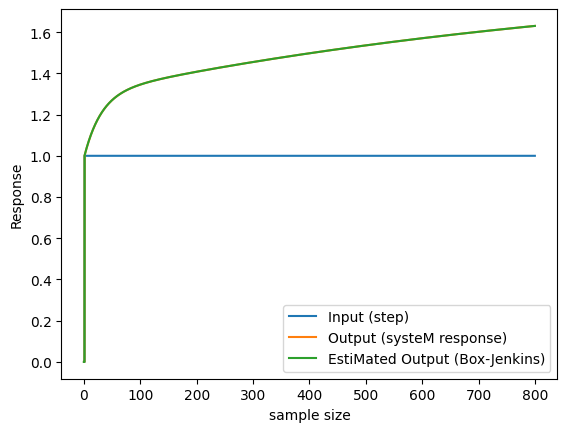

In [21]:
fig, ax = plt.subplots()
ax.plot(t[:M-6], u_step[:M-6], label="Input (step)")
ax.plot(tout[:M-6], yout[:M-6], label="Output (systeM response)")
ax.plot(tout[:M-6], y_hat, label="EstiMated Output (Box-Jenkins)")
ax.set_xlabel("sample size")
ax.set_ylabel("Response")
ax.legend()
plt.show()

In [22]:
# Extract estimated transfer function
estimated_tf, _ = sid.theta_2_tf_box_jenkins(optimization_results.x, n_bj, Ts=dt)
num_est, den_est = estimated_tf.num, estimated_tf.den
num_est = num_est[0][0]  # Extract the numerator array
den_est = den_est[0][0]  # Extract the denominator array

print("Estimated Transfer Function (Discrete):")
print(estimated_tf)

Estimated Transfer Function (Discrete):
<TransferFunction>: sys[1780]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


0.8763 z^2 - 1.752 z + 0.8755
-----------------------------
   z^2 - 1.999 z + 0.9994

dt = 0.01



In [23]:
print("den_est:", den_est)
print("Shape of den_est:", np.shape(den_est))


den_est: [ 1.         -1.99937351  0.99937352]
Shape of den_est: (3,)


In [24]:
# den_est = den_est[0]  # Extract the first array from the list

# Convert Discrete Transfer Function to Continuous-Time
poles_discrete = np.roots(den_est) 
T = dt  # Sampling time

In [25]:
print(poles_discrete)

[0.99997936 0.99939415]


In [26]:
print(num_est, den_est)

[ 0.87626256 -1.75173359  0.87547106] [ 1.         -1.99937351  0.99937352]


In [27]:
print(estimated_tf.num)

[[array([ 0.87626256, -1.75173359,  0.87547106])]]


In [ ]:
# import numpy as np
# from scipy.signal import residue

# def proper_fraction_expansion(num, den):
#     """
#     Converts an improper transfer function into a strictly proper form.
#     Returns quotient (b0) and the remainder's numerator.
#     """
#     #quotient, remainder = np.polydiv(num, den)
#     quotient = num[0] 
#     remainder = np.empty(len(num)-1)
#     for ii in range(len(remainder)):
#         remainder[ii] = num[ii+1] - num[0]*den[ii+1]                    
#     return quotient, remainder

# def partial_fraction_expansion(num, den):
#     """
#     Performs manual partial fraction expansion of H(z) = (b1*z + b2 +b0) / ((z - p1) * (z - p2)).
#     Returns poles and corresponding coefficients A and B.
#     """
#     # Find poles
#     poles = np.roots(den)
#     p1, p2 = poles
    
#     # Extract numerator coefficients
#     b1, b2 = num 
    
#     # Compute coefficients A and B
#     A = (b1 * p1 + b2) / (p1 * (p1 - p2))
#     B = (b1 * p2 + b2) / (p2 * (p2 - p1))
    
#     return poles, (A, B)



# # Convert to proper fraction
# quotient, remainder = proper_fraction_expansion(num_est, den_est)
# b0 = quotient

# # Perform partial fraction expansion
# poles, (A, B) = partial_fraction_expansion(remainder, den_est)

# # Print results
# print(f"Quotient (b0): {b0}")


# print("\nCustom Partial Fraction Expansion:")
# print("Poles:", poles)
# print(f"A: {A}")
# print(f"B: {B}")

Quotient (b0): 0.876262555855998

Custom Partial Fraction Expansion:
Poles: [0.99997936 0.99939415]
A: 9.027349985304526e-06
B: 0.00023366275389857956


In [32]:
def partial_fraction(num_est, den_est):
    """
    Compute the partial fraction coefficients A, B, and C for the given transfer function.

    Parameters:
        num_est (list): Coefficients of the numerator [b2, b1, b0].
        den_est (list): Coefficients of the denominator [1, a1, a0].
        p1 (float): First pole.
        p2 (float): Second pole.

    Returns:
        dict: A dictionary containing A, B, and C.
    """
    
    # Find poles
    poles = np.roots(den)
    p1, p2 = poles
    
    b2, b1, b0 = num_est
    a0 = den_est[-1]
    
    # Compute num(-p1) and num(-p2)
    num_neg_p1 = b2 * (-p1) ** 2 + b1 * (-p1) + b0
    num_neg_p2 = b2 * (-p2) ** 2 + b1 * (-p2) + b0
    
    # Compute A and B using given formulas
    A = num_neg_p1 / ((-p1) * (-p1 + p2))
    B = num_neg_p2 / ((-p2) * (-p2 + p1))
    
    # Compute C using given formula
    C = b0 / a0
    
    return poles, (A, B)





poles, (A, B) = partial_fraction(num_est, den_est)
print("Poles:", poles)
print(f"A: {A}")
print(f"B: {B}")


Poles: [0.9995+0.01999375j 0.9995-0.01999375j]
A: (0.0001329489024804944-87.60529790861276j)
B: (0.0001329489024804944+87.60529790861276j)


In [35]:
TF1 = ct.tf(np.array([A, 0]),np.array([1, -poles[0]]),dt)
TF2 = ct.tf(np.array([B, 0]),np.array([1, -poles[1]]),dt)
print(TF1)
print(TF2)
print("gotten:",TF1+TF2+C)
print("Est:", estimated_tf)

print()

<TransferFunction>: sys[1792]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


 87.61 z
----------
z - 0.9997

dt = 0.01

<TransferFunction>: sys[1793]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


 87.61 z
----------
z - 0.9997

dt = 0.01

gotten: <TransferFunction>: sys[1796]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


0.8763 z^2 + 1.752 z + 0.8755
-----------------------------
   z^2 - 1.999 z + 0.9994

dt = 0.01

Est: <TransferFunction>: sys[1780]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


0.8763 z^2 - 1.752 z + 0.8755
-----------------------------
   z^2 - 1.999 z + 0.9994

dt = 0.01




In [131]:
print(b0)

0.876262555855998


In [ ]:
# Compute a1 and a2 from discrete-to-continuous transformation
poles_continuous = np.log(poles_discrete) / T  # Using z = e^(sT) -> s = log(z)/T
a1, a2 = poles_continuous

In [ ]:
print(a1,a2)

In [ ]:
tau1 = 1/a1
tau2 = 1/a2

print(tau1,tau2)

In [ ]:
# Compute R1, C1, R2, C2 from a1 and a2

# partial fraction expansion on the discrete data.
R1_est = -1 / (a1 * C1)
R2_est = -1 / (a2 * C2)

print(f"Estimated Parameters:\n R1 = {R1_est:.4f} Ω \n R2 = {R2_est:.4f} Ω")

In [ ]:
# import scipy.signal as signal
# # Convert Discrete Transfer Function to Continuous-Time using Bilinear Transformation
# H_s = signal.dlti(num_est, den_est, dt=T)
# H_s_cont = H_s.to_continuous(method='bilinear')

# print("Estimated Transfer Function (Continuous):")
# print(H_s_cont)
